
# TP Final Tecnologias Exponenciales
### Integrantes:
- Juan Ignacio F.
- Lucas C.
- Joaquim R.
- Federico S.

## Nuestro Problema

Elegimos analizar archivos ejecutables para detectar si se tratan de malware o no.

---

Para lograr esto interpretamos los bytes del archivo como si fueran de uno .png, produciendo las extrañas imagenes que se ven en las siguientes celdas. Estas imagenes luego son analizadas por **Redes Neuronales Convolucionales** o CNNs, las cuales estan especialmente hechas para encontrar patrones y caracteristicas en datos de varias dimensiones como lo son las imagenes o el sonido.


---


Para entrenar el modelo elegimos un dataset que ya convirtio los ejecutables en imagenes, aunque los datos no estan del todo listo para ser analizados. El dataset contiene dos clases, malware, y software benigno. Existian opciones con diversas clases de malware pero preferimos diferenciar el software benigno del maligno.

### Imports y descarga del dataset

In [ ]:
!apt install subversion 
#instalamos subversion para clonar solo una carpeta de un repositorio de github, la del dataset

!svn checkout https://github.com/suryateja0153/Malware-Classification-TensorFlow/trunk/Code/Level_1_Two-Class/split_images/split_images
#clonamos la carpeta

!pip install keras-visualizer

from keras_visualizer import visualizer
from google.colab.patches import cv2_imshow
from google.colab import files
from math import log
from PIL import Image
from keras.models import Sequential
from keras import layers, losses
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dropout, Dense
import tensorflow as tf
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
!mkdir custom_ims # creamos el directorio donde guardaremos las imagenes que crearemos
!mkdir custom_ims/malware
!mkdir custom_ims/benignware
root = "/content/custom_ims"

## Constantes y preparacion de datos


#### Conversor de .exe/.bytes a .png

Saving WetPlantUI.exe to WetPlantUI.exe


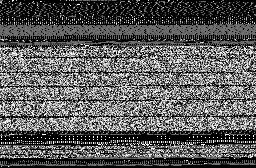

In [ ]:
# declaramos una funcion que convierta nuestros archivos .exe a un array strings de la representacion hexadecimal
# de bytes para luego convertirlo a.png
def file_to_byte_arr(path):
  hexdata = open(path, "rb").read().hex() 
  #leemos el archivo  en formato hexadecimal a travez de su directorio, nos devuelve un poco util string de todos los bytes
  hexlist = list(map(''.join, zip(hexdata[::2], hexdata[1::2])))
  #mediante este map trunco los bytes cada dos caracteres, (2 char hex = 1 byte), luego lo casteo a lista donde cada elemento es un byte
  arr = [] # creo un array para usar luego
  string = "0 " # este es el indice del renglon de bytes, siempre va a ser 0 ya que no lo uso luego
  for i, val in enumerate(hexlist): # por cada indice y valor en la lista de valores hexadecimales...
    string+=(val.upper()+" ") # a nuestro string le sumo el valor y un espacio
    if len(string.split())==17: # si tenemos 17 elementos en nuestro string separando por espacios (16 bytes + indice)
      arr.append(string) # agregamos el string a nuestro array
      string = "0 " # y reseteamos el string
  return arr

# declaramos una funcion que toma un array de numpy de los valores decimales de los bytes hexadecimales y cambia su forma de (x,) a (a,b),
# donde b es una potencia de 2 y la forma es lo mas cuadrada posible, luego lo transforma a una imagen .png
def convertAndSave(array,name, clase):
  if array.shape[1]!=16: # si el array no tiene datos hexadecimales
      assert(False)
  b=int((array.shape[0]*16)**(0.5))     #- chona no te voy a mentir, estas 5 lineas de codigo son copiadisimas y estan años luz por encima de mi entendimiento,
  b=2**(int(log(b)/log(2))+1)           #- pero todo lo otro es producto de mi sangre, sudor y lagrimas, asi que espero que me la perdones porque es solo para
  a=int(array.shape[0]*16/b)            #- poder decir que el modelo me clasifico el .exe de WetPlant como malware ;)
  array=array[:a*b//16,:]               #- 
  array=np.reshape(array,(a,b))         #- (creditos a Manu Oribe por decirme lo que se supone que hace la funcion)

  im = Image.fromarray(np.uint8(array)) # convertimos el array a una imagen de PIL
  im.save(root+'/'+clase+'/'+name+'.png', "PNG")  # guardamos la imagen
  return im

# declaramos una funcion que tome el nombre del archivo .exe o .bytes
# y lo transforme a png utilizando las otras dos funciones
def process_file(name, clase):
  array = [] # declaramos un array vacio para usarlo luego
  file = None # declaramos la variable file para asignarla luego
  if name[-6:] == ".bytes": # si la extencion es .bytes...
    file = open(name) # abrimos el archivo e iteramos directamente
  else: # sino...
    file = file_to_byte_arr(name) # procesamos el .exe primero
  for line in file: # por cada linea en nuestro array de strings...
    xx=line.split() # partimos el string por cada espacio
    if len(xx)!=17: # si la longitud de la subdivision no es la misma que la inicial
      continue
    array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
    # agregamos a nuestro array vacio los valores hexadecimales traducidos a decimal si el valor no es "??", (3F),
    # sin contar el primer elemento de cada renglon ya que es el indice
  
  im = convertAndSave(np.array(array), name, clase) # llamamos el metodo de convertir a .png
  im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR) # convertimos la imagen de formato RGB a BGR para verla con cv2
  cv2_imshow(im) # mostramos la imagen
  return im
src = files.upload() # subimos archivos
name = list(src.keys())[0]
im = process_file(name, "benignware") # procesamos el archivo a partir de su nombre

#### Creacion del Dataset

In [ ]:
!rmdir /content/custom_ims/.ipynb_checkpoints
# borramos un directorio que se crea automaticamente para que se cree propiamente el dategaen

train_dir = "/content/split_images/train/" # especificamos donde se ubican las imagenes de entrenamiento
                                          # la estructira de los directorios es la siguiente:
                                          # entrenamiento --> malware/software normal
                                          # validacion --> malware/software normal
generator = ImageDataGenerator(rescale = 1./255) 
# declaramos un generdor, este va a normalizar los valores de los pixeles entre 0 y 1

# creamos el data generator a partir del directorio,
# este genera un objeto comprensible por el modelo que crearemos luego,
# organiza los valores de entrada y le da sus respectivos valores de salida dependiendo de en que directorio esta,
# tambien escla todas las imagenes al mismo tamaño para que puedan ser procesadas, y las convierte a escala de grises
# para que sea mas facil procesarlas. Por ultimo seteamos el batch size a 10 lo que nos dice que por cada epoch
# se pasan 10 muestras.
train_datagen = generator.flow_from_directory(
                                              train_dir,
                                              color_mode='grayscale',
                                              target_size=(256,256),
                                              batch_size=10,
                                              class_mode='binary'
                                             )

# hacemos lo mismo para los datos de validacion, hay que notar que en el print de abajo se ven que son muchos menos que los de entrenamiento 
test_dir = "/content/split_images/val/"
test_datagen = generator.flow_from_directory(
                                             test_dir,
                                             color_mode='grayscale',
                                             target_size=(256,256),
                                             batch_size=10,
                                             class_mode='binary'
                                            )
# creamos un datagen con las imagenes convertidas de .exe/.bytes a .png
custom_dir = "/content/custom_ims/"
custom_datagen = generator.flow_from_directory(
                                               custom_dir,
                                               color_mode='grayscale',
                                               target_size=(256,256),
                                               batch_size=10,
                                               class_mode='binary'
                                              )

Found 1134 images belonging to 2 classes.
Found 285 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


### Visualizacion del dataset

In [ ]:
custom_datagen.class_indices # que valor corresponde a que clase

{'benignware': 0, 'malware': 1}

In [ ]:
print(len(train_datagen), "--> Cantidad de batches\n")
print(train_datagen[0][0].shape, "--> Forma de cada batch\n") # La forma de (batch_size, ancho, alto, canales)
print(len(train_datagen[0]), "La longitud de la tupla es 2 por los datos de entrada y salida\n")
print(type(train_datagen[0]), "--> Tipo del contenedor de los datos de entrada\n") # El indice 0 de la primera tupla son los datos de entrada
print(type(train_datagen[0][0]), "--> Tpo de cada imagen\n") # Las imagenes son arrays de numpy para que el modelo de redes neuronales lo pueda manipular bien
print(type(train_datagen[0][1]), "-- Tipo de los datos de salida de cada batch\n") # Devuelta un array de numpy, esto es lo que realmente ve el modelo
print(len(train_datagen[0][1]), "--> Longitud de cada batch, hay un valor de salida por imagen\n")
# Los valores verdaderos son 0 o 1, las predicciones estan en este rango

print(train_datagen[0][0][0][0], "--> primera columna de la primera imagen del dataset\n")
# la forma de la imagen es (256,256), es una imagen de 256x256 px en escala de grises
print(train_datagen[0][1][0], "--> su valor de salida")

# para los otros datagens la estructura se mantiene

114 --> Cantidad de batches

(10, 256, 256, 1) --> Forma de cada batch

2 La longitud de la tupla es 2 por los datos de entrada y salida

<class 'tuple'> --> Tipo del contenedor de los datos de entrada

<class 'numpy.ndarray'> --> Tpo de cada imagen

<class 'numpy.ndarray'> -- Tipo de los datos de salida de cada batch

10 --> Longitud de cada batch, hay un valor de salida por imagen

[[0.3019608 ]
 [0.3529412 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.       

Muestra de imagen de entrenamiento de malware


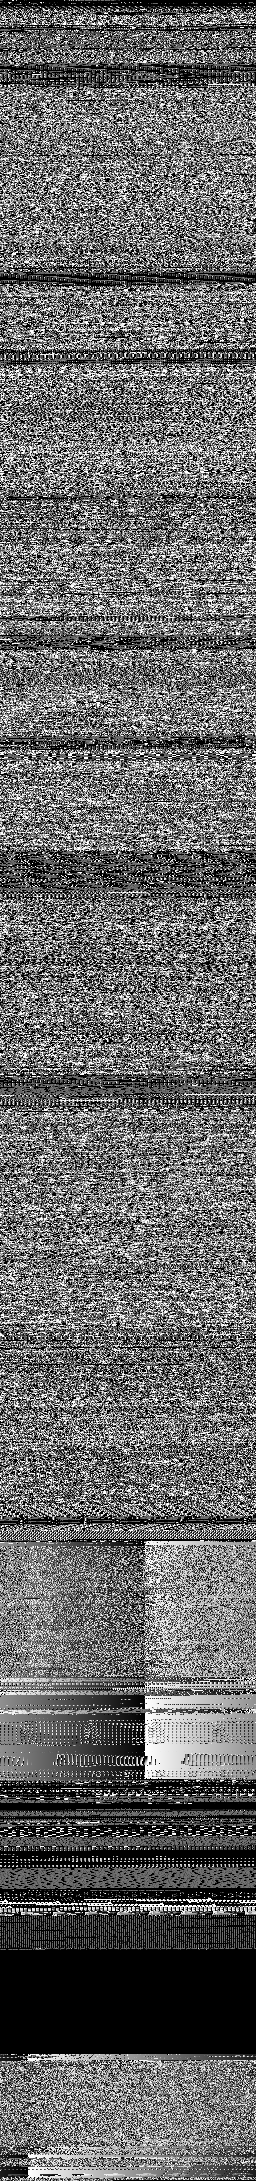




Muestra de imagen de entrenamiento de software benigno


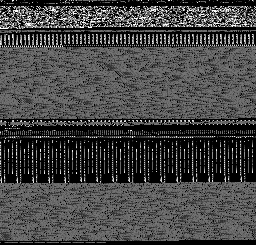

In [ ]:
train_malware_path = train_dir+"malware/"
train_malware = os.listdir(train_malware_path)

train_benignware_path = train_dir+"benignware/"
train_benignware = os.listdir(train_benignware_path)

print("Muestra de imagen de entrenamiento de malware")
cv2_imshow(cv2.imread(train_malware_path+train_malware[0]))
print("\n\n")
print("Muestra de imagen de entrenamiento de software benigno")
cv2_imshow(cv2.imread(train_benignware_path+train_benignware[0]))

### Creamos y entrenamos el modelo

###¿Que es una red neuronal?

Finalmente nos ponemos a analizar los datos. Como funciona esto? Los modelos de redes neuronales toman tensores como entrada y devuelven otros como salida,
para hacer esto aplican transformaciones. 

---

### Ejemplo
En el caso de querer tomar valores de temperatura de grados celcius como entrada y en grados farenheit como salida, esto seria tan simple como multiplicar el valor por 9/5 y sumarle 32. Esto es una sobresimplificacion de lo que hacen los modelos con solo capas densas, o los
modelos de regresion lineal. Multiplican el valor de entrada por un peso y le suman un sesgo. 

La cosa se pone interesante cuando a esa entrada de un solo valor se le aplican varias transformaciones con varias neuronas, las cuales luego se conectan densamente con las de otra capa de transformaciones, con cada conexion teniendo un solo peso y sesgo. Esto produce que la activacion, (el evento de un valor de salida significante), de una neurona produce la activacion de otra dependiendo del peso de su conexion. Por esto distintos estimulos activan distintas neuronas en la primera capa, lo que activa distintas neuronas en las siguientes capas. En otras palabras, ciertas caracteristicas en la entrada activan ciertas neuronas que las detectan, en base a esto, las neuronas de las siguientes capas detectan caracteristicas un poco mas abstractas en base a la combinacion de las detectadas anteriormente, (esto ultimo no puede pasar en modelos con operaciones puramente lineales)

Todo esto seria inutil de todos modos porque todas las operaciones equivaldrian a la formula original, en otras palabras, al aplicar muchas operaciones lineales el resultado se puede expresar con una sola operacion lineal.

![NN gif](https://community.alteryx.com/t5/image/serverpage/image-id/42339i8BA3F2CCCEDE7458?v=v2)

---
### ¿Y los problemas no lineales?
Para un problema tan basico no nos importaria, pero un concepto abstracto como decidir si un archivo ejecutable es malware o no, no puede ser resuelto con una
simple formula de la forma y=mx+b, por lo que tenemos que usar herramientas como las funciones de activacion. 

Las funciones de activacion son simplemente funciones no lineales aplicadas a todas las salidas de las neuronas de la capa a la que se la da. De esta manera los problemas no lineales pueden ser resueltos con modelos densos, pero para lograr analizar imagenes debemos ir mas alla.

La siguiente imagen es de la funcion de activacion ReLu, la que elimina los valores de salida negativos

![ReLu](https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png)

--- 

# CNN
Para analizar una imagen debemos usar Redes Neuronales Convolucionales, especificamente hechas para esto, detectan caracteristicas abstractas en datos
multidimensionales independientemente de variaciones en la manifestacion de la caracteristica, (por ejemplo si hago un clasificador de perros y gatos),
deberia poder clasificar cualquier raza de perro como perro, o lo detectaria si esta en el centro de la imagen o a un costado o dado vuelta.

Las caracteristicas que las capas convolucionales encuentran son luego analizadas por un modelo denso. Esto se asemeja a como nuestros cerebros procesas estimulos visuasles, al ver a un perro reconocemos el contorno de sus orejas, su forma, y sabemos lo que es eso, lo mismo con sus patas, nariz, cola, etc. Esto lo sabemos aunque sea un pitbull, un caniche, o que este a 1 metro, 2, o dado vuelta. Al juntar estas caracteristicas pensamos, "ah! es un perro".

El siguiente gif es de una convolucion con padding, (estos conceptos se explican mejor en los comentarios abajo):

![CNN gif](https://www.megabagus.id/wp-content/uploads/2019/10/CNN2-gif.gif)


In [ ]:
# funcion que crea el modelo

def crearModelo():
  modelo = tf.keras.Sequential([
  layers.Input(shape=(256,256,1)), # capa de entrada, la forma de la entrada es la especificada antes en el generador
  Conv2D(32, (5,5), strides=4, activation='relu', padding="same"), 
  # capa convolucional, escencial para la clasificacion de imagenes, aplicamos 32 filtros con un kerner de 5x5
  # las capas convolucionales aplican filtros, a las imagenes con el objetivo de encontrar patrones en estas como contornos o colores distintivos de las clases
  # esto lo hacen aplicando transformaciones a la imagen a travez de una matriz cuadrada llamada kernel, la cual es desplazada en la imagen transformandola,
  # cada posicion del kernel aplica una operacion distinta. El stride nos dice cuantas casillas se mueve el kernel por cada vez que aplica la transformacion,
  # basicamente nos dice si pasamos por pixeles mas de una vez o nos salteamos alguno.
  # tambien aplicamos padding en la capa, lo que añade pixeles con valor 0 alrededor de la imagen para prevenir que el kernel no llegue a todos los pixeles

  MaxPooling2D((2,2)),
  # la capa de maxpooling aplica un kernel a la imagen como la capa de convolucion, pero en este caso toma un promedio
  # de los pixeles del kernel, reduciendo el tamaño de la imagen para que solo las caracteristicas resaltadas por las capas convolucionales prevalezcan
  # estas capas se concatena con las de convolucion para obtener imagenes mas pequeñas a las que se les pueden aplicar mas filtros,
  # el parametro es el tamaño del kernel

  Conv2D(32, (5,5), strides=4, activation='relu', padding='same'), # aplicamos otra capa igual
  MaxPooling2D((2,2)), # seguimos concatenando capas de pooling
  Conv2D(64, (4,4), strides=2, activation='relu', padding='same'), # capa de convolucion con mas filtros y un kernel mas chico
  MaxPooling2D((2,2)), # otra capa mas de pooling...
  Conv2D(128, (1,1), padding='same'), #capa de convolucion con aun mas filtros y menor kernel
  Flatten(),
  #aplanamos los datos para analizarlos con capas densas, esto significa concatenar todas las filas de la matriz que es la imagen entre si formando 
  # una enorme fila, para que luego a la capa densa le entren todos los pixeles de una como un vector de una dimension

  # analizamos las caracteristicas que encontraron las capas convolucionales con capas densas que encuentren patrones en estas
  Dense(units=512, activation='relu'),
  Dense(units=128, activation='relu'),
  Dropout(0.2), 
  # aplicamos una capa de dropout que "mate" a 1/5 de las neuronas para prevenir que solo unas pocas sean activadas, esta regularizacion
  # es util solo en estas capas ya que tienen miles de parametros 
  Dense(units=64, activation='relu'),
  # agregamos una capa densa que analize las conclusiones de la capa anterior
  Dense(1, activation='sigmoid')
  # agregamos una ultima neurona cuya activacion sea sigmoide, lo que significa que sus valores quedan entre 0 y 1,
  #lo que necesitamos para saber cuan cerca de una clase o la otra esta la prediccion
  ])

  # compilamos el modelo indicandole las funciones de coste, el optimizador, y que metrica usar para la presicion
  modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
  )
  return modelo
modelo = crearModelo()

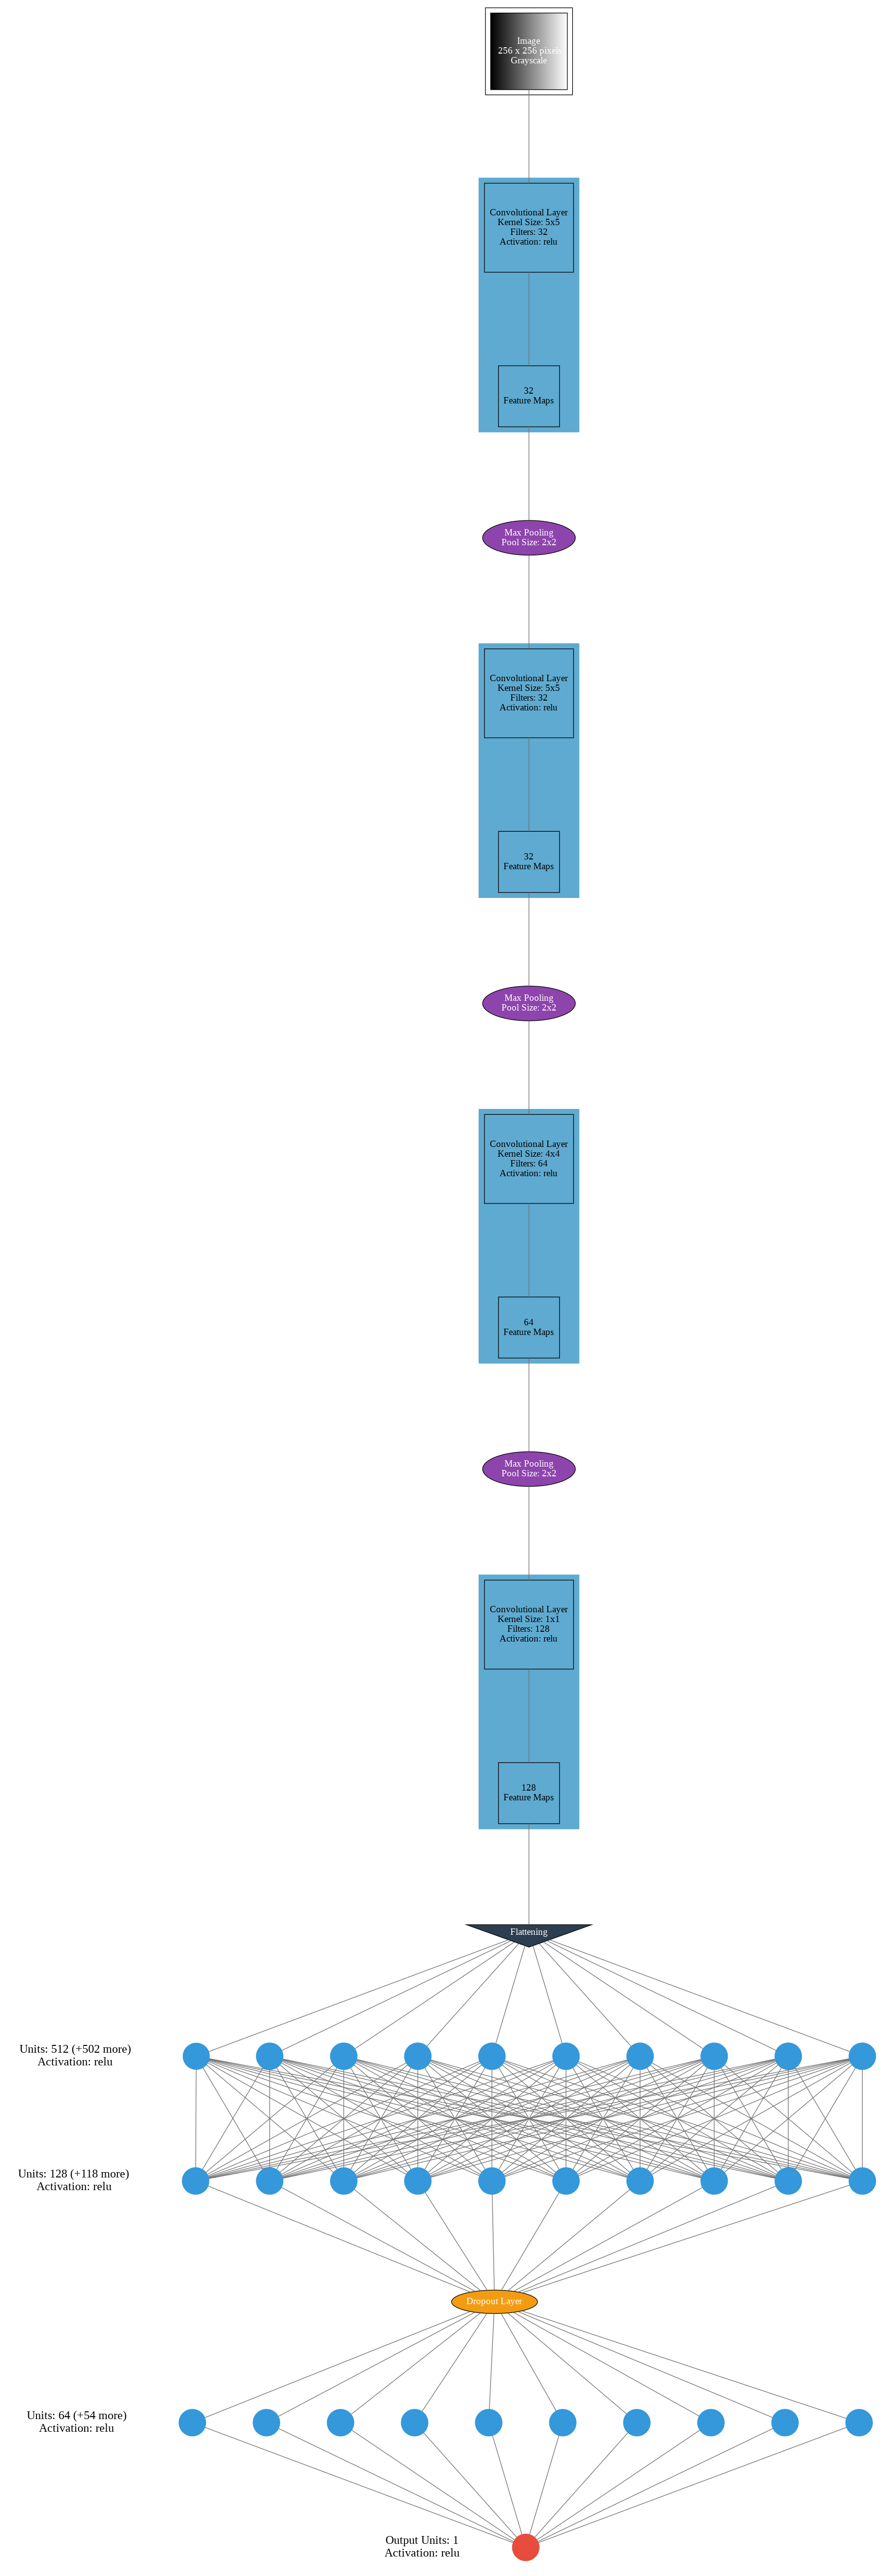

In [ ]:
visualizer(modelo, filename="modelo", format='png', view=True)
cv2_imshow(cv2.imread("modelo.png"))

In [ ]:
history = modelo.fit_generator(train_datagen, 
                               steps_per_epoch=20,
                               validation_data=test_datagen,
                               validation_steps=20,
                               epochs=100)

# entrenamos el modelo, le pasamos el generador de entrenamiento y validacion, la cantidad de epochs y los pasos por epoch
# una epoch es el entrenamiento de un batch entero

# al entrenar, todos los parametros son inicializados aleatoriamente. Se hacen predicciones, al comparar con los valores deseados se calcula el error o coste
# y en base a este el algoritmo de optimizacion cambia los parametros entrenables de la red para minimizar el error


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


20/20 [==============================] - 10s 75ms/step - loss: 0.6322 - accuracy: 0.7050 - val_loss: 0.5865 - val_accuracy: 0.7350
Epoch 2/100
20/20 [==============================] - 1s 66ms/step - loss: 0.4428 - accuracy: 0.7250 - val_loss: 0.3721 - val_accuracy: 0.7000
Epoch 3/100
20/20 [==============================] - 1s 67ms/step - loss: 0.3741 - accuracy: 0.7550 - val_loss: 0.3686 - val_accuracy: 0.8450
Epoch 4/100
20/20 [==============================] - 1s 70ms/step - loss: 0.2586 - accuracy: 0.8950 - val_loss: 0.2515 - val_accuracy: 0.8750
Epoch 5/100
20/20 [==============================] - 1s 67ms/step - loss: 0.2242 - accuracy: 0.9050 - val_loss: 0.2855 - val_accuracy: 0.9000
Epoch 6/100
20/20 [==============================] - 1s 65ms/step - loss: 0.1795 - accuracy: 0.9250 - val_loss: 0.2644 - val_accuracy: 0.8950
Epoch 7/100
20/20 [==============================] - 1s 69ms/step - loss: 0.2017 - accuracy: 0.9124 - val_loss: 0.1859 - val_accuracy: 0.9200
Epoch 8/100
20/20

### Visualizacion del rendimiento

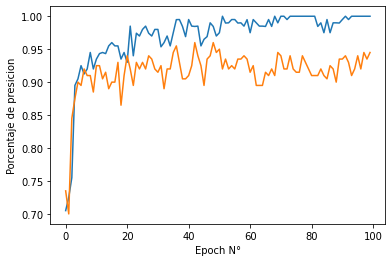

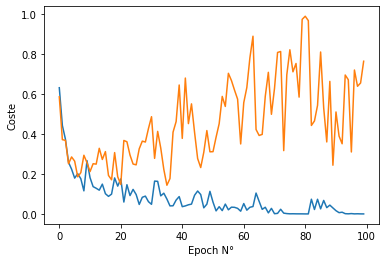

In [ ]:
# definimos funciones para graficar el rendimineto

def show_acc(hist):
  plt.plot(hist['accuracy'], label='Entrenamiento')
  plt.plot(hist['val_accuracy'], label='Prueba')
  plt.xlabel('Epoch N°')
  plt.ylabel('Porcentaje de presicion')
  plt.show()

def show_loss(hist):
  plt.plot(hist['loss'], label='Entrenamiento')
  plt.plot(hist['val_loss'], label='Prueba')
  plt.xlabel('Epoch N°')
  plt.ylabel('Coste')
  plt.show()

show_acc(history.history)
show_loss(history.history)

#### Como podemos ver el modelo tiene una buena presicion tanto para los datos de entrenamiento como los de validacion, aunque no se puede decir lo mismo del coste de validacion, el cual definitivamente podria ser optimizado.

### Predicciones puntuales

In [ ]:
# Podemos predecir todos los datos de entrenamiento
# iteramos en el datagen de prueba e imprimimos la prediccion junto con el valor verdadero
def predict_all_test():
  for i in range(len(test_datagen[0][0])):
    for j in range(10):
      print(round(modelo.predict(test_datagen[i][0])[j][0], 3))
      print(test_datagen[i][1][j])

predict_all_test()

1/1 [==============================] - 0s 124ms/step
0.0
0.0
1/1 [==============================] - 0s 17ms/step
1.0
1.0
1/1 [==============================] - 0s 19ms/step
0.0
0.0
1/1 [==============================] - 0s 16ms/step
0.0
0.0
1/1 [==============================] - 0s 17ms/step
0.0
0.0
1/1 [==============================] - 0s 20ms/step
0.006
1.0
1/1 [==============================] - 0s 20ms/step
0.0
0.0
1/1 [==============================] - 0s 18ms/step
0.0
0.0
1/1 [==============================] - 0s 23ms/step
0.0
0.0
1/1 [==============================] - 0s 20ms/step
0.0
0.0
1/1 [==============================] - 0s 17ms/step
0.0
0.0
1/1 [==============================] - 0s 19ms/step
0.0
0.0
1/1 [==============================] - 0s 17ms/step
0.0
0.0
1/1 [==============================] - 0s 19ms/step
1.0
1.0
1/1 [==============================] - 0s 18ms/step
1.0
1.0
1/1 [==============================] - 0s 17ms/step
1.0
1.0
1/1 [==============================] 

In [ ]:
# O podemos predecir nuestros archivos .exe/.bytes individualmente
# predecimos y verificamos las imagenes personalizadas
print(modelo.predict(custom_datagen[0][0]))
print(custom_datagen[0][1])

1/1 [==============================] - 0s 68ms/step
[[0.9999994]]
[0.]


Como podemos ver, estamos equivocados, WetPlant es malware :(